## __Objective:__ Create a multiclass image classifier

## __Purpose:__ Can be used to classify  species of animal

### Use transfer learning and vgg16 model

### importing necessary libraries

In [16]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Loading up our image datasets

In [17]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data3/train'  
validation_data_dir = 'data3/validation'  
test_data_dir = 'data3/test'
   
# number of epochs to train top model  
epochs = 32 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 60  

In [18]:
#importing weights from imagenet

In [19]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [20]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

# Creation of weights/features with VGG16

In [21]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 18826 images belonging to 10 classes.
Time:  0:00:58.323278


In [22]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [23]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 638 images belonging to 10 classes.
Time:  0:00:02.459754


In [24]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [25]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 264 images belonging to 10 classes.
Time:  0:00:01.847408


# Loading training, validation and testing data

In [26]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 18826 images belonging to 10 classes.


In [27]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 638 images belonging to 10 classes.


In [28]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 264 images belonging to 10 classes.


# Training of model

In [29]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
from keras.layers.advanced_activations import LeakyReLU
LR = LeakyReLU(alpha=0.3)
LR.__name__ = 'relu'
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=LR))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=LR))  
model.add(Dropout(0.3)) 
model.add(Dense(50, activation=LR))  
model.add(Dropout(0.3)) 
model.add(Dense(50, activation=LR))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=epochs,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 18826 samples, validate on 638 samples
Epoch 1/32
18826/18826 [==============================] - 4s 205us/step - loss: 1.6216 - acc: 0.4435 - val_loss: 0.5860 - val_acc: 0.9028
Epoch 2/32
18826/18826 [==============================] - 3s 174us/step - loss: 0.7750 - acc: 0.7528 - val_loss: 0.2431 - val_acc: 0.9545
Epoch 3/32
18826/18826 [==============================] - 3s 178us/step - loss: 0.4902 - acc: 0.8414 - val_loss: 0.1724 - val_acc: 0.9545
Epoch 4/32
18826/18826 [==============================] - 3s 173us/step - loss: 0.3717 - acc: 0.8813 - val_loss: 0.1387 - val_acc: 0.9624
Epoch 5/32
18826/18826 [==============================] - 3s 172us/step - loss: 0.3067 - acc: 0.9044 - val_loss: 0.1322 - val_acc: 0.9734
Epoch 6/32
18826/18826 [==============================] - 3s 174us/step - loss: 0.2586 - acc: 0.9192 - val_loss: 0.1286 - val_acc: 0.9687
Epoch 7/32
18826/18826 [==============================] - 3s 173us/step - loss: 0.2442 - acc: 0.9249 - val_loss: 0.1224 - va

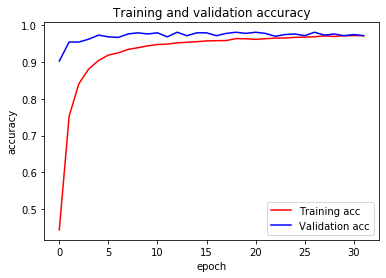

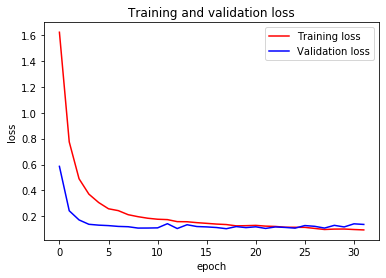

In [30]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation on Testing Set

In [31]:
model.evaluate(test_data, test_labels)

264/264 [==============================] - 0s 167us/step


[0.05402342962836635, 0.9886363636363636]

### Confusion Matrix

In [20]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [21]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [22]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
#         print()
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)+1)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


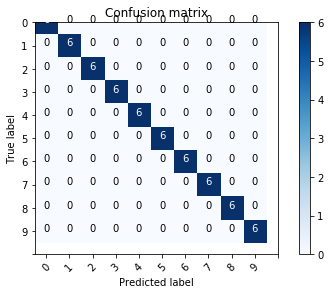

In [23]:
plot_confusion_matrix(confusion_matrix,['0', '1','2','3','4','5','6','7','8','9'])

Normalized confusion matrix


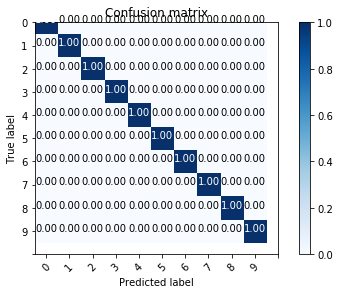

In [24]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['0', '1','2','3','4','5','6','7','8','9'],
                     normalize=True)

## Testing images on model

In [34]:
def read_image(file_path):
#     print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [35]:
def test_single_image(path):
    animals = ['0', '1','2','3','4','5','6','7','8','9']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,10), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  

    return load_img(path)

In [42]:
path = 'test/b00004.png'
# os.chdir('training-a')

ID: 0, Label: 0 0.0%
ID: 1, Label: 1 0.0%
ID: 2, Label: 2 0.0%
ID: 3, Label: 3 0.0%
ID: 4, Label: 4 0.0%
ID: 5, Label: 5 99.99%
ID: 6, Label: 6 0.0%
ID: 7, Label: 7 0.0%
ID: 8, Label: 8 0.0%
ID: 9, Label: 9 0.0%
Final Decision:
.
..
...
ID: 5, Label: 5


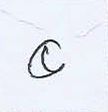

In [43]:
test_single_image(path)

In [32]:
import joblib
joblib.dump(vgg16, 'mlbrain_CNNvgg.joblib')

['mlbrain_CNNvgg.joblib']

In [33]:
joblib.dump(model, 'mlbrain_CNNmodel.joblib')

['mlbrain_CNNmodel.joblib']